# 1. Imports and setup

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# PortfolioBacktester class (with fixed performance_metrics method)
class PortfolioBacktester:
    def __init__(self, price_data, weights, initial_cash=100000):
        self.price_data = price_data.sort_index()
        self.weights = weights
        self.initial_cash = initial_cash
        self.tickers = list(weights.keys())
        self._validate_inputs()

    def _validate_inputs(self):
        total_weight = sum(self.weights.values())
        if not np.isclose(total_weight, 1):
            raise ValueError(f"Weights must sum to 1. Current sum: {total_weight}")
        missing = [t for t in self.tickers if t not in self.price_data.columns]
        if missing:
            raise ValueError(f"Tickers missing from price data: {missing}")

    def run_backtest(self):
        normalized_prices = self.price_data / self.price_data.iloc[0]
        weighted_prices = normalized_prices * pd.Series(self.weights)
        portfolio_norm = weighted_prices.sum(axis=1)
        portfolio_value = portfolio_norm * self.initial_cash
        return portfolio_value.to_frame(name="Portfolio Value")

    def plot_performance(self, portfolio_value):
        plt.figure(figsize=(12,6))
        plt.plot(portfolio_value.index, portfolio_value["Portfolio Value"], label="Portfolio Value")
        plt.title("Backtested Portfolio Performance")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value ($)")
        plt.legend()
        plt.grid(True)
        plt.show()

    def calculate_returns(self, portfolio_value):
        returns = portfolio_value.pct_change().dropna()
        return returns

    def performance_metrics(self, returns):
        annualized_return = returns.mean() * 252
        annualized_vol = returns.std() * np.sqrt(252)
        if isinstance(annualized_return, pd.Series) and len(annualized_return) == 1:
            annualized_return = annualized_return.item()
        if isinstance(annualized_vol, pd.Series) and len(annualized_vol) == 1:
            annualized_vol = annualized_vol.item()
        sharpe_ratio = annualized_return / annualized_vol if annualized_vol != 0 else np.nan
        return {
            "Annualized Return": annualized_return,
            "Annualized Volatility": annualized_vol,
            "Sharpe Ratio": sharpe_ratio
        }



# 2. Load price data

In [6]:

DATA_DIR = "../data/processed"
tickers = ["TSLA", "BND", "SPY"]

price_data = pd.DataFrame()
for ticker in tickers:
    file_path = os.path.join(DATA_DIR, f"{ticker}_processed.csv")
    df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    price_data[ticker] = df['Adj Close']

price_data.head()

,TSLA,BND,SPY
2015-07-01,31518000.0,5399300.0,135979900.0
2015-07-02,107458500.0,1060100.0,104373700.0
2015-07-03,107458500.0,1060100.0,104373700.0
2015-07-06,61828500.0,2210700.0,117975400.0
2015-07-07,91576500.0,4183200.0,173820200.0


# 3. Define portfolio weights (must sum to 1)



In [7]:
weights = {"TSLA": 0.5, "BND": 0.3, "SPY": 0.2}

# 4. Initialize backtester and run backtest

In [8]:
backtester = PortfolioBacktester(price_data, weights)
portfolio_value = backtester.run_backtest()

# 5. Plot portfolio performance

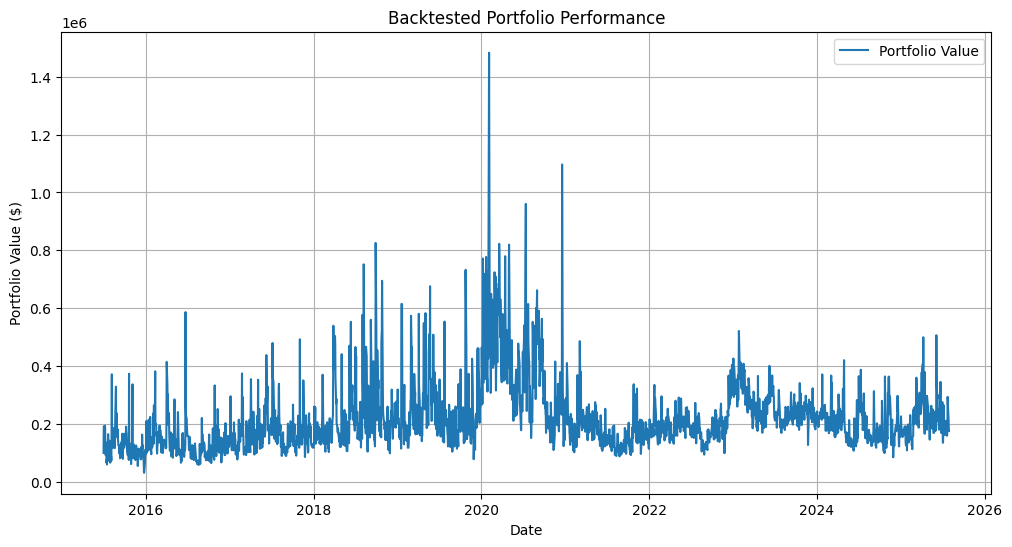

In [9]:
backtester.plot_performance(portfolio_value)

# 6. Calculate and display returns and performance metrics

In [10]:
returns = backtester.calculate_returns(portfolio_value)
metrics = backtester.performance_metrics(returns)

print("Backtest Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Backtest Performance Metrics:
Annualized Return: 12.2459
Annualized Volatility: 5.8874
Sharpe Ratio: 2.0800
